<a href="https://colab.research.google.com/github/MuktaUbale/comparing-VITs/blob/main/test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip -q install vit_pytorch linformer

ERROR: Could not install packages due to an OSError: [Errno 13] Permission denied: '/cs/cs152/venv/lib/python3.11/site-packages/einops'
Check the permissions.



In [1]:
from __future__ import print_function

import glob
from itertools import chain
import os
import random
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import torch
import torchvision
import torchvision.transforms as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# from linformer import Linformer
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms
from tqdm.notebook import tqdm
import torch.optim as optim

from torchvision.models import resnet50
from vit_pytorch.distill import DistillableViT, DistillWrapper

In [2]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:1


In [3]:
print(f"Torch: {torch.__version__}")

Torch: 2.0.1+cu117


In [4]:
# Training settings
batch_size = 64
epochs = 20
lr = 3e-5
gamma = 0.7
seed = 42

In [5]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

In [6]:
# create the data transform that DeiT expects
transform = T.Compose([
    T.Resize(256, interpolation=3),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [7]:
os.makedirs('data', exist_ok=True)

train_dir = 'data/train'
test_dir = 'data/test'

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)

val_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                      download=True, transform=transform)

val_size = 0.2
num_train = len(train_dataset)
indices = list(range(num_train))
split = int(np.floor(val_size * num_train))

np.random.seed(seed)
np.random.shuffle(indices)

train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(valid_idx)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [8]:
num_train = len(train_dataset)
num_test = len(test_dataset)
print(num_train, num_test)

50000 10000


In [9]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                           sampler=train_sampler, pin_memory=True,)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size,
                                           sampler=val_sampler, pin_memory=True,)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [10]:
print(len(train_loader), len(val_loader), len(test_loader))

625 157 157


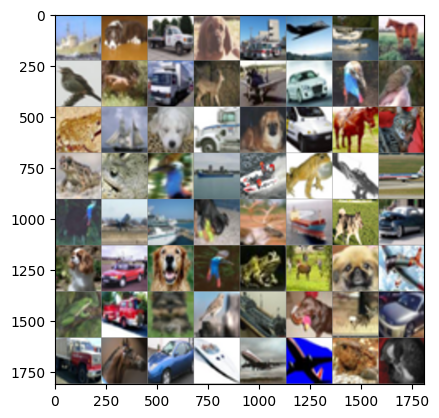

ship               dog                truck              dog                truck              plane              plane              horse              bird               deer               truck              deer               plane              car                bird               bird               frog               ship               dog                truck              dog                car                horse              cat                frog               frog               bird               ship               ship               frog               plane              plane              bird               plane              ship               dog                deer               ship               dog                car                dog                car                dog                bird               frog               deer               dog                plane              frog               truck              dog                bird               ship        

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:18s}' for j in range(batch_size)))

# Efficient Attention

# Training

In [12]:
teacher = resnet50(pretrained = True).to(device)

model = DistillableViT(
    image_size = 256,
    patch_size = 32,
    num_classes = 1000,
    dim = 1024,
    depth = 6,
    heads = 8,
    mlp_dim = 2048,
    dropout = 0.1,
    emb_dropout = 0.1
).to(device)


distiller = DistillWrapper(
    student = model,
    teacher = teacher,
    temperature = 3,           # temperature of distillation
    alpha = 0.5,               # trade between main loss and distillation loss
    hard = False               # whether to use soft or hard distillation
).to(device)

# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

/cs/cs152/venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/cs/cs152/venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:
trainingEpoch_loss = []
validationEpoch_loss = []

for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0
    running_loss = 0.0

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        output = model(inputs)
        loss = distiller(inputs, labels) # not using output?
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == labels).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)

        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # print every 200 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

    print(f'Epoch {epoch}')

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in val_loader:
            data = data.to(device)
            label = label.to(device)

            val_output = model(data)
            val_loss = criterion(val_output, label) # which loss

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(val_loader)
            epoch_val_loss += val_loss / len(val_loader)

    trainingEpoch_loss.append(epoch_loss.cpu().detach())
    validationEpoch_loss.append(epoch_val_loss.cpu().detach())

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
        )


[1,   200] loss: 0.189
[1,   400] loss: 0.161
[1,   600] loss: 0.152
Epoch 0
Epoch : 1 - loss : 1.6689 - acc: 0.3774 - val_loss : 1.4923 - val_acc: 0.4536

[2,   200] loss: 0.145
[2,   400] loss: 0.143
[2,   600] loss: 0.140
Epoch 1
Epoch : 2 - loss : 1.4252 - acc: 0.5202 - val_loss : 1.3336 - val_acc: 0.5153

[3,   200] loss: 0.135
[3,   400] loss: 0.135
[3,   600] loss: 0.133
Epoch 2
Epoch : 3 - loss : 1.3407 - acc: 0.5731 - val_loss : 1.2332 - val_acc: 0.5577

[4,   200] loss: 0.128
[4,   400] loss: 0.128
[4,   600] loss: 0.127
Epoch 3
Epoch : 4 - loss : 1.2753 - acc: 0.6108 - val_loss : 1.1841 - val_acc: 0.5770

[5,   200] loss: 0.122
[5,   400] loss: 0.123
[5,   600] loss: 0.123
Epoch 4
Epoch : 5 - loss : 1.2247 - acc: 0.6414 - val_loss : 1.1556 - val_acc: 0.5896

[6,   200] loss: 0.118
[6,   400] loss: 0.118
[6,   600] loss: 0.119
Epoch 5
Epoch : 6 - loss : 1.1809 - acc: 0.6716 - val_loss : 1.1325 - val_acc: 0.5985

[7,   200] loss: 0.114
[7,   400] loss: 0.114
[7,   600] loss: 0

In [14]:
trainingEpoch_loss

[tensor(1.6689),
 tensor(1.4252),
 tensor(1.3407),
 tensor(1.2753),
 tensor(1.2247),
 tensor(1.1809),
 tensor(1.1408),
 tensor(1.1029),
 tensor(1.0648),
 tensor(1.0263),
 tensor(0.9900),
 tensor(0.9552),
 tensor(0.9233),
 tensor(0.8912),
 tensor(0.8659),
 tensor(0.8413),
 tensor(0.8224),
 tensor(0.8070),
 tensor(0.7907),
 tensor(0.7775)]

<function matplotlib.pyplot.show(close=None, block=None)>

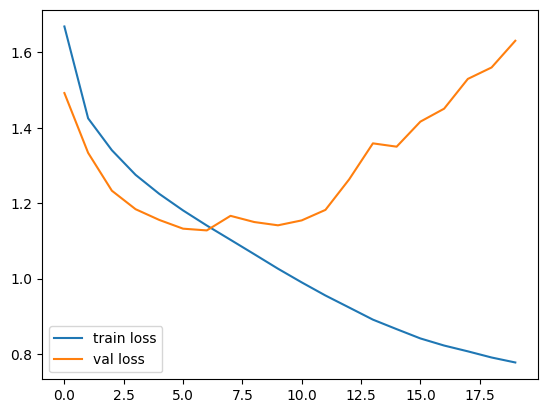

In [15]:
from matplotlib import pyplot as plt
plt.plot(trainingEpoch_loss, label='train loss')
plt.plot(validationEpoch_loss,label='val loss')
plt.legend()
plt.show

In [17]:
trainingEpoch_loss

[tensor(0.7770, device='cuda:1', grad_fn=<AddBackward0>)]

The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.


In [19]:
trainingEpoch_loss

[tensor(0.7770, device='cuda:1', grad_fn=<AddBackward0>)]

TypeError: can't convert cuda:1 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

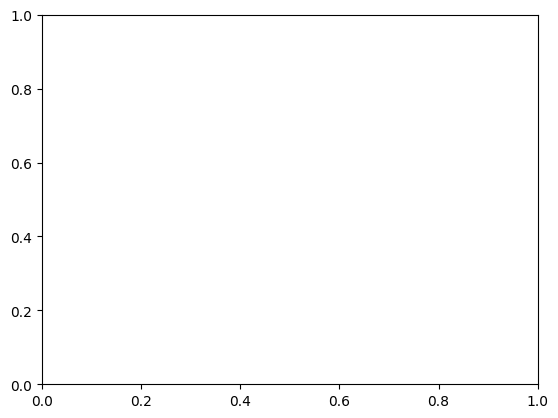

In [21]:
from matplotlib import pyplot as plt
plt.plot(trainingEpoch_loss, label='train loss')
plt.plot(validationEpoch_loss,label='val loss')
plt.legend()
plt.show

In [25]:
trainingEpoch_loss

[tensor(0.7770, device='cuda:1', grad_fn=<AddBackward0>)]